# MIT-BIH-Arr Dataset Creation
In this notebook, we create TS from the MIT-BIH data archive. Annotation codes are available at: https://www.physionet.org/physiotools/wpg/wpg_36.htm

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import daproli as dp

import pandas as pd

pd.set_option('display.max_rows', None)

import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import sys
import wfdb
import os

sys.path.append("../../")

from tqdm import tqdm
from src.visualization import plot_time_series
from scipy.signal import butter, filtfilt

First, we need to download the PhysioNet record and annotation from https://physionet.org/content/mitdb/1.0.0/.

In [3]:
subject = 207

In [4]:
rec = wfdb.rdrecord(f"{subject}", pn_dir='mitdb')

In [5]:
ann = wfdb.rdann(f"{subject}", "atr", pn_dir='mitdb')

In [10]:
name = f"MIT-BIH_{rec.sig_name[0]}_{rec.sig_name[1]}_Subject{subject}"
ts = rec.p_signal[:, 0]

In [11]:
def create_labeled_segments(ts, ann, min_label_ratio=0.5, fs=360.0):
    unique_symbols = np.unique(ann.symbol)
    symbol_to_int = {symbol: idx for idx, symbol in enumerate(unique_symbols)}

    seg_symbols = ''.join(ann.symbol).split("+")[1:]

    segments = []
    labels = []
    new_cps = [0]

    # Use rhythm changes as CPs
    cps = np.array(ann.sample)[np.array(ann.symbol) == "+"][1:]
    cps = np.concatenate(([0], cps, [len(ts)]))

    for i, symbols in enumerate(seg_symbols):
        symbols_list = list(symbols)
        unique, counts = np.unique(symbols_list, return_counts=True)
        percents = counts / np.sum(counts)

        # Determine most occurring label in segment 
        max_idx = np.argmax(counts)
        dominant_symbol = unique[max_idx]
        dominant_percent = percents[max_idx]
        dominant_label = symbol_to_int[dominant_symbol]

        # Add segment, CP, label - filter noise
        if dominant_percent >= min_label_ratio and (len(labels) == 0 or labels[-1] != dominant_label):
            segment = ts[cps[i]:cps[i + 1]]

            if len(segment) < 10 * fs:
                continue

            segments.append(segment)
            new_cps.append(new_cps[-1] + len(segment))
            labels.append(symbol_to_int[dominant_symbol])

    if len(labels) == 0: labels = [0]
    return np.concatenate(segments), np.array(new_cps)[1:-1], np.array(labels)


ts, cps, labels = create_labeled_segments(ts, ann)

In [12]:
# Filter noise from ECG
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=360.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

Let's visualise the example TS.

<Axes: title={'center': 'MIT-BIH_MLII_V1_Subject207'}>

<Figure size 640x480 with 0 Axes>

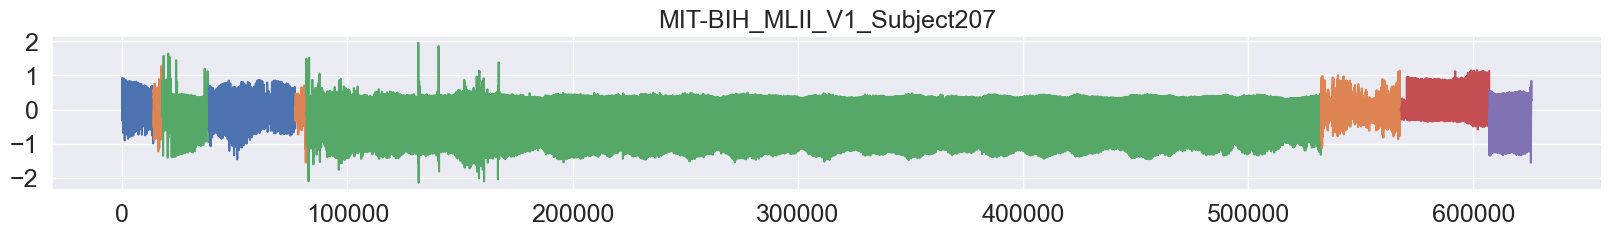

In [13]:
plot_time_series(name, bandpass_filter(ts), cps, labels)

Finally, let's save the entire TS dataset.

In [22]:
DATASET_PATH = "../../datasets/MIT-BIH/"

In [23]:
if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)

In [24]:
records = pd.read_csv("https://physionet.org/files/mitdb/1.0.0/RECORDS", header=None)[0].to_numpy()

desc, prop = [], []
data = dict()
window_size = 360

for subject in tqdm(records):
    rec = wfdb.rdrecord(f"{subject}", pn_dir='mitdb')
    ann = wfdb.rdann(f"{subject}", "atr", pn_dir='mitdb')

    name = f"MIT-BIH_{rec.sig_name[0]}_Subject{subject}"
    ts, cps, labels = create_labeled_segments(rec.p_signal[:, 0], ann)

    if len(cps) == 0: continue
    ts = bandpass_filter(ts)

    desc.append(f"{name},{window_size},{','.join(dp.map(str, cps))}")
    prop.append(f"{name},{','.join(dp.map(str, labels))}")
    data[name] = ts

np.savetxt(f"{DATASET_PATH}desc.txt", desc, fmt="%s")
np.savetxt(f"{DATASET_PATH}properties.txt", prop, fmt="%s")
np.savez(f"{DATASET_PATH}data.npz", **data)

100%|██████████| 48/48 [04:55<00:00,  6.15s/it]
